# Generating Super-Resolution medical images 

---

Super-resolution is a technique that aims to improve the quality of images, by taking a low-resolution image and enhancing it to make it look sharper and clearer. This process is extensively explored in the field of image processing. However, there are a couple of problems that researchers often encounter. One issue is related to the methods that use interpolation. Interpolation-based techniques try to estimate the missing details in the low-resolution image by making educated guesses based on the available information. Unfortunately, these methods often result in blurry output, where the enhanced image lacks sharpness and fine details.

Stable Diffusion uses an AI algorithm to upscale images, eliminating the need for manual work that may require manually filling gaps in an image. It has been trained on millions of images and can accurately predict high-resolution images, resulting in a significant increase in detail compared to traditional image upscalers. Additionally, unlike non-deep-learning techniques such as nearest neighbor, Stable Diffusion takes into account the context of the image, using a textual prompt to guide the upscaling process.

In this notebook, we demonstrate how to enhance CT Scans.

<img src="ctscan_dog.png" alt= "CT Scan Dog Paws" align="center">


We use SageMaker Python SDK for Upscaling with state-of-the-art pre-trained Stable Diffusion models. Upscaling is the task of generating high resolution image given a low resolution image and a textual prompt describing the image. An image that is low resolution, blurry, and pixelated can be converted into a high resolution image that appears smoother, clearer, and more detailed. This process, called upscaling, can be applied to both real images and images generated by [text-to-image Stable Diffusion models](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/). This can be used to enhance image quality in various industries such as e-commerce and real estate, as well as for artists and photographers. Additionally, upscaling can improve the visual quality of low-resolution images when displayed on high-resolution screens.

---

1. [Set Up](#1.-Set-Up)
2. [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
3. [Query endpoint and parse response](#3.-Query-endpoint-and-parse-response)
4. [Clean up the endpoint](#4.-Clean-up-the-endpoint)

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: After you’re done running the notebook, make sure to delete all resources so that all the resources that you created in the process are deleted and your billing is stopped. Code in [Clean up the endpoint](#5.-Clean-up-the-endpoint) deletes model and endpoints that are created.

### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets.

---

In [2]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.27.69 requires botocore==1.29.69, but you have botocore 1.29.142 which is incompatible.
awscli 1.27.69 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.27.69 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.142 which is incompatible.

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip i

#### Permissions and environment variables

---
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### 2. Retrieve Artifacts & Deploy an Endpoint

***
Amazon SageMaker enables customers to train, fine-tune, and run inference using Hugging Face models. You can use Hugging Face for both training and inference. This functionality is available through the development of Hugging Face AWS Deep Learning Containers. These containers include Hugging Face Transformers, Tokenizers and the Datasets library, which allows you to use these resources for your training and inference jobs. For a list of the available Deep Learning Containers images, see Available Deep Learning Containers Images. These Deep Learning Containers images are maintained and regularly updated with security patches.

To use the Hugging Face Deep Learning Containers with the SageMaker Python SDK for training, see the Hugging Face SageMaker Estimator. With the Hugging Face Estimator, you can use the Hugging Face models as you would any other SageMaker Estimator. However, using the SageMaker Python SDK is optional. You can also orchestrate your use of the Hugging Face Deep Learning Containers with the AWS CLI and AWS SDK for Python (Boto3).

In this notebook, we use the Stable Diffusion x4 upscaler. You can find the model card here (https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler)

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [4]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

(model_id, model_version,) = (
    "model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16",
    "*",
)

endpoint_name = name_from_base(f"medical-example-{model_id}")

# Instances with more GPU memory supports generation of larger images.
# Please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

# Retrieve the model uri. This includes the pre-trained model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

----------!

### 3. Query endpoint and parse response

---
Input to the endpoint is a prompt, a low resolution image and image generation parameters in json format and encoded in `utf-8` format. Output of the endpoint is a `json` with generated images and the input prompt.

---

#### 3.1 Download example low resolution image
---
Let's have a look at a low resolution portion of an image that we would like to enhance.

---

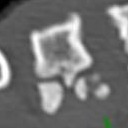

In [11]:
from IPython.display import Image

low_res_img_file_name = "ctscan.jpeg"

# Displaying the original image
Image(filename=low_res_img_file_name, width=632, height=632)

Next we write some helper function for querying the endpoint, parsing the response and display generated image.


In [12]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the generated images and prompt."""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
Below, we put in the example low resolution image and a prompt. You can put in any text and any image and the model generates the corresponding upscaled image. Note that model generates an image of size up to four times the original image. So, putting a very large input image may result in CUDA memory issue. To address this, either input a low resolution image or select an instance type with large CUDA memory such as ml.g5.2xlarge. 

---

#### Supported Parameters

***
This model supports many parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **noise_level**: add noise to latent vectors before upscaling. If specified, it must be an integer.

***

In [17]:
import base64
from PIL import Image
from io import BytesIO


# content_type = 'application/json;jpeg', endpoint expects payload to be a json with the low resolution jpeg image as bytes encoded with base64.b64 encoding.
# To send raw image to the endpoint, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
content_type = "application/json;jpeg"


# We recommend rescaling the image of low_resolution_image such that both height and width are powers of 2.
# This can be achieved by original_image = Image.open('low_res_image.jpg'); rescaled_image = original_image.rescale((128,128)); rescaled_image.save('rescaled_image.jpg')
# Example image used in this tutorial is of size 128x128.

with open(low_res_img_file_name, "rb") as f:
    low_res_image_bytes = f.read()
encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()

payload = {
    "prompt": "xray ct scan",
    "image": encoded_image,
    "num_inference_steps": 100,
    "guidance_scale": 15,
}

# For accept = 'application/json;jpeg', endpoint returns the jpeg image as bytes encoded with base64.b64 encoding.
# To receive raw image with rgb value set Accept = 'application/json'
accept = "application/json;jpeg"

# Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.

query_response = query(model_predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
generated_images, prompt = parse_response(query_response)

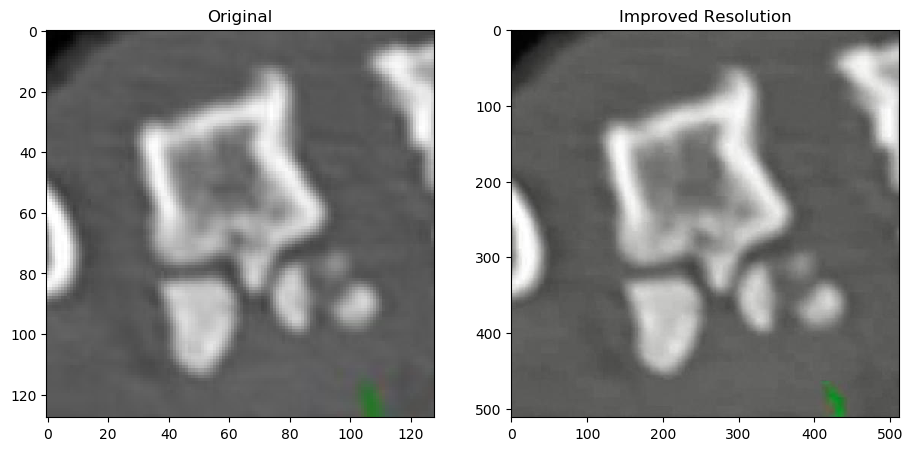

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# For accept = 'application/json;jpeg' mentioned above, returned image is a jpeg as bytes encoded with base64.b64 encoding.
# Here, we decode the image and display the image.
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")

    img_enhanced_name = 'upscaled_ctscan.jpg'
    generated_image_rgb.save(img_enhanced_name)
    # read images
    img_original = mpimg.imread(low_res_img_file_name)
    img_enhanced = mpimg.imread(img_enhanced_name)

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_original)
    ax[0].title.set_text('Original')
    ax[1].imshow(img_enhanced)
    ax[1].title.set_text('Improved Resolution')
    

### 4. Clean up the endpoint

***
After you’re done running the notebook, make sure to delete all resources created in the process to ensure that the billing is stopped.
***

In [8]:
# Delete the SageMaker endpoint
#model_predictor.delete_model()
#model_predictor.delete_endpoint()